In [1]:
from IPython.display import Audio
import random
import pickle
import os
os.system("pip install kaggle")
import pathlib

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [2]:
SEED = 100

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

pd.set_option('display.max_columns', 100)

In [3]:
SAMPLE_RATE = 16000
ACCEPTED_FORMATS = ["wav", "WAV"]

DURATION = 3
FRAME_LENGTH_DURATION_IN_MS = 25
FRAME_SKIP_DURATION_IN_MS = 12

N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128

BATCH_SIZE = 8
EPOCHS = 100

AUDIO_DATA_PATH = pathlib.Path("E:/Desktop/StutterDetModel/data")
IMG_DATA_PATH = pathlib.Path("E:/Desktop/StutterDetModel/Tensorflow_models/test_spec_img")

In [4]:
pathlib.Path(IMG_DATA_PATH)

WindowsPath('E:/Desktop/StutterDetModel/Tensorflow_models/test_spec_img')

In [5]:
def create_mel_spec_images(source_audio_path, info_df, dest_img_path, column_name):
    if not os.path.exists(dest_img_path):
        os.mkdir(dest_img_path)
    if not os.path.exists(os.path.join(dest_img_path, pathlib.Path("1"))):
        os.mkdir(os.path.join(dest_img_path, pathlib.Path("1")))
    if not os.path.exists(os.path.join(dest_img_path, pathlib.Path("0"))):
        os.mkdir(os.path.join(dest_img_path, pathlib.Path("0")))

    info_df = info_df.set_index("FileName")
    for file_name, info in info_df.iterrows():

        save_file_name = file_name.split(".")[0]
        if info[column_name] == 0:
            folder_name = pathlib.Path("0")
        else:
            folder_name = pathlib.Path("1")


        audio_path = os.path.join(source_audio_path, pathlib.Path(file_name))
        if file_name.split(".")[-1] not in ACCEPTED_FORMATS:
            continue
        try:
            audio, _ = librosa.load(audio_path, sr=SAMPLE_RATE, duration=DURATION)
        except Exception as e:
            print(f"\t[-] Audio {file_name} is invalid!")
            continue
        if audio.size < DURATION*SAMPLE_RATE:
            pad_size = DURATION*SAMPLE_RATE - audio.size
            audio = np.pad(audio, pad_width=(0, pad_size))
        melspec = librosa.feature.melspectrogram(
            y=audio,
            sr=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS
        )
        melspec = librosa.power_to_db(melspec, ref=np.max)
        
        plt.figure(figsize=(3, 3))
        librosa.display.specshow(melspec, sr=SAMPLE_RATE, y_axis="mel", x_axis="time")
        plt.axis(False)
        plt.savefig(
            os.path.join(dest_img_path, folder_name, pathlib.Path(save_file_name + ".jpg")), 
            bbox_inches='tight', 
            pad_inches=0
        )
        plt.close()

In [6]:
full_df = pd.read_csv(os.path.join(AUDIO_DATA_PATH, "SEP28K-Extended.csv"))
print(full_df.shape)
full_df.head()

(27409, 11)


,Unnamed: 0,SEP12k,SEP28k-E,SEP28k-T,SEP28k-D,Prolongation,Block,Interjection,FileName,NoStutter,Repetition
0,0,NaN,train,test,test,0.0,0.0,0.0,HeStutters_0_0.wav,1.0,0.0
1,1,NaN,train,test,test,0.0,0.0,0.0,HeStutters_0_1.wav,1.0,0.0
2,2,NaN,train,test,test,0.0,0.0,0.0,HeStutters_0_2.wav,1.0,0.0
3,3,NaN,train,test,test,0.0,0.0,0.0,HeStutters_0_3.wav,1.0,0.0
4,4,NaN,train,test,test,0.0,0.0,0.0,HeStutters_0_4.wav,1.0,0.0


In [7]:
full_df["SEP28k-E"].unique()

array(['train', 'test', 'dev'], dtype=object)

In [8]:
train_df = full_df[full_df["SEP28k-E"] == "train"]
print(train_df.shape)
train_df.head()

(14788, 11)


,Unnamed: 0,SEP12k,SEP28k-E,SEP28k-T,SEP28k-D,Prolongation,Block,Interjection,FileName,NoStutter,Repetition
0,0,NaN,train,test,test,0.0,0.0,0.0,HeStutters_0_0.wav,1.0,0.0
1,1,NaN,train,test,test,0.0,0.0,0.0,HeStutters_0_1.wav,1.0,0.0
2,2,NaN,train,test,test,0.0,0.0,0.0,HeStutters_0_2.wav,1.0,0.0
3,3,NaN,train,test,test,0.0,0.0,0.0,HeStutters_0_3.wav,1.0,0.0
4,4,NaN,train,test,test,0.0,0.0,0.0,HeStutters_0_4.wav,1.0,0.0


In [9]:
train_df = train_df[train_df["Prolongation"] == 0]
train_df = train_df[train_df["Interjection"] == 0]
train_df = train_df[train_df["Block"] == 0]
neg_count, pos_count = train_df["Repetition"].value_counts()
pos_weight = neg_count / pos_count
print(neg_count, pos_count, pos_weight, len(train_df))
print(neg_count / len(train_df))

7246 1694 4.2774498229043685 8940
0.8105145413870246


In [10]:
val_df = full_df[full_df["SEP28k-E"] == "dev"]
print(val_df.shape)
val_df.head()

(6208, 11)


,Unnamed: 0,SEP12k,SEP28k-E,SEP28k-T,SEP28k-D,Prolongation,Block,Interjection,FileName,NoStutter,Repetition
43,43,train,dev,dev,train,0.0,0.0,1.0,HeStutters_1_3.wav,1.0,0.0
61,62,train,dev,dev,train,0.0,0.0,0.0,HeStutters_1_22.wav,1.0,0.0
71,72,train,dev,dev,train,1.0,0.0,1.0,HeStutters_1_32.wav,0.0,0.0
72,73,train,dev,dev,train,0.0,0.0,0.0,HeStutters_1_33.wav,0.0,1.0
80,81,train,dev,dev,train,1.0,0.0,0.0,HeStutters_1_41.wav,0.0,0.0


In [11]:
val_df = val_df[val_df["Prolongation"] == 0]
val_df = val_df[val_df["Interjection"] == 0]
val_df = val_df[val_df["Block"] == 0]
print(val_df["Repetition"].value_counts())
print(len(val_df))
print(val_df["Repetition"].value_counts()[0] / len(val_df))

Repetition
0.0    3114
1.0     787
Name: count, dtype: int64
3901
0.7982568572160984


In [12]:
test_df = full_df[full_df["SEP28k-E"] == "test"]
print(test_df.shape)
test_df.head()

(6413, 11)


,Unnamed: 0,SEP12k,SEP28k-E,SEP28k-T,SEP28k-D,Prolongation,Block,Interjection,FileName,NoStutter,Repetition
11,11,train,test,train,dev,0.0,0.0,0.0,HeStutters_0_11.wav,1.0,0.0
26,26,train,test,train,dev,0.0,0.0,0.0,HeStutters_0_26.wav,1.0,0.0
27,27,train,test,train,dev,0.0,0.0,0.0,HeStutters_0_27.wav,0.0,1.0
29,29,train,test,train,dev,0.0,0.0,0.0,HeStutters_0_29.wav,1.0,0.0
30,30,train,test,train,dev,0.0,0.0,0.0,HeStutters_0_30.wav,1.0,0.0


In [13]:
test_df = test_df[test_df["Prolongation"] == 0]
test_df = test_df[test_df["Interjection"] == 0]
test_df = test_df[test_df["Block"] == 0]
print(test_df["Repetition"].value_counts())
print(len(test_df))
print(test_df["Repetition"].value_counts()[0] / len(test_df))

Repetition
0.0    3310
1.0     733
Name: count, dtype: int64
4043
0.8186989859015582


In [29]:
train_sample = train_df.sample(1000)
train_sample["Repetition"].value_counts()

Repetition
0.0    802
1.0    198
Name: count, dtype: int64

In [30]:
train_sample["Repetition"].value_counts()[0] / train_sample["Repetition"].value_counts()[1]

4.05050505050505

In [31]:
val_sample = val_df.sample(200)
val_sample["Repetition"].value_counts()

Repetition
0.0    152
1.0     48
Name: count, dtype: int64

In [32]:
test_sample = test_df.sample(200)
test_sample["Repetition"].value_counts()

Repetition
0.0    164
1.0     36
Name: count, dtype: int64

In [33]:
# Create the data

# Train data
create_mel_spec_images(
    os.path.join(AUDIO_DATA_PATH,pathlib.Path("clips/stuttering-clips/clips")),
    train_sample,
    os.path.join(IMG_DATA_PATH,pathlib.Path("train")),
    "Repetition"
)

# Val data
create_mel_spec_images(
    os.path.join(AUDIO_DATA_PATH,pathlib.Path("clips/stuttering-clips/clips")),
    val_sample,
    os.path.join(IMG_DATA_PATH,pathlib.Path("val")),
    "Repetition"
)

# Test data
create_mel_spec_images(
    os.path.join(AUDIO_DATA_PATH,pathlib.Path("clips/stuttering-clips/clips")),
    test_sample,
    os.path.join(IMG_DATA_PATH,pathlib.Path("test")),
    "Repetition"
)

In [ ]:
tf.strings.join()

In [51]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(IMG_DATA_PATH, pathlib.Path("train")),
    labels="inferred",
    label_mode="int",
    class_names=["0", "1"],
    image_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(IMG_DATA_PATH, pathlib.Path("val")),
    labels="inferred",
    label_mode="int",
    class_names=["0", "1"],
    image_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(IMG_DATA_PATH, pathlib.Path("test")),
    labels="inferred",
    label_mode="int",
    class_names=["0", "1"],
    image_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [61]:
def build_model(input_shape=(256, 256, 3), dropout_rate=0.5):
    inp = layers.Input(input_shape)

    x = layers.Conv2D(
        64, 
        kernel_size=(3, 3), 
        padding="same",
        activation="relu"
    ) (inp)
    x = layers.Conv2D(
        64, 
        kernel_size=(3, 3), 
        padding="same",
        activation="relu"
    ) (x)
    x = layers.MaxPool2D((2, 2)) (x)
    x = layers.BatchNormalization() (x)

    x = layers.Conv2D(
        128, 
        kernel_size=(3, 3), 
        padding="same",
        activation="relu"
    ) (x)
    x = layers.Conv2D(
        128, 
        kernel_size=(3, 3), 
        padding="same",
        activation="relu"
    ) (x)
    x = layers.MaxPool2D((2, 2)) (x)
    x = layers.BatchNormalization() (x)

    x = layers.Conv2D(
        256, 
        kernel_size=(3, 3), 
        padding="same",
        activation="relu"
    ) (x)
    x = layers.Conv2D(
        256, 
        kernel_size=(3, 3), 
        padding="same",
        activation="relu"
    ) (x)
    x = layers.MaxPool2D((2, 2)) (x)
    x = layers.BatchNormalization() (x)

    x = layers.TimeDistributed(layers.Flatten()) (x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Attention() ([x, x])
    x = layers.Flatten() (x)

    x = layers.Dense(
        512,
        activation="relu"
    ) (x)
    x = layers.Dropout(dropout_rate) (x)
    x = layers.Dense(
        128,
        activation="relu"
    ) (x)
    x = layers.Dropout(dropout_rate) (x)
    out = layers.Dense(1) (x)

    model = Model(inp, out)

    return model

model = build_model()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 256, 256, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_37 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_36[0][0]']              
                                )                                                           

In [62]:
def weighted_binary_cross_entropy(pos_weight):
    return lambda y_true, y_pred: tf.nn.weighted_cross_entropy_with_logits(
                labels=tf.cast(y_true, tf.float32),
                logits=tf.cast(y_pred, tf.float32), 
                pos_weight=tf.constant(pos_weight)
            )
            

In [63]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
    ),
    loss=weighted_binary_cross_entropy(pos_weight),
    metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall()]
)

In [64]:
history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    epochs=50,
    verbose=1,
    callbacks=[
        # callbacks.EarlyStopping(
        #     monitor="val_loss", 
        #     patience=15, 
        #     verbose=1, 
        #     restore_best_weights=True
        # ),
        callbacks.ReduceLROnPlateau(
            monitor = 'binary_accuracy',
            factor = 0.2,
            patience = 5,
            verbose = 1,
            min_lr = 0.0001
        )
    ],
    # validation_data=val_data,
).history

Epoch 1/50


125/125 [==============================] - 29s 192ms/step - loss: 10.1341 - binary_accuracy: 0.5680 - precision_5: 0.1905 - recall_5: 0.3636 - lr: 0.0100
Epoch 2/50
125/125 [==============================] - 26s 207ms/step - loss: 1.3883 - binary_accuracy: 0.7340 - precision_5: 0.2213 - recall_5: 0.1364 - lr: 0.0100
Epoch 3/50
125/125 [==============================] - 26s 208ms/step - loss: 1.1645 - binary_accuracy: 0.7750 - precision_5: 0.1351 - recall_5: 0.0253 - lr: 0.0100
Epoch 4/50
125/125 [==============================] - 26s 206ms/step - loss: 1.1713 - binary_accuracy: 0.7960 - precision_5: 0.1250 - recall_5: 0.0051 - lr: 0.0100
Epoch 5/50
125/125 [==============================] - 26s 207ms/step - loss: 1.1485 - binary_accuracy: 0.7940 - precision_5: 0.2500 - recall_5: 0.0202 - lr: 0.0100
Epoch 6/50
125/125 [==============================] - 26s 207ms/step - loss: 1.1467 - binary_accuracy: 0.8000 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - lr: 0.0100
Epoch 7/50
125/125

KeyboardInterrupt: 

In [60]:
2 * (0.4457 * 0.4141) / (0.4457 + 0.4141)

0.4293193068155385

In [ ]:
model.evaluate(val_data)

25/25 [==============================] - 2s 57ms/step - loss: 1.1996 - binary_accuracy: 0.7500 - precision_2: 0.4000 - recall_2: 0.0833


[1.1995810270309448, 0.75, 0.4000000059604645, 0.0833333358168602]

In [ ]:
model.evaluate(test_data)

25/25 [==============================] - 2s 67ms/step - loss: 1.1027 - binary_accuracy: 0.7900 - precision_2: 0.2000 - recall_2: 0.0556


[1.1027207374572754,
 0.7900000214576721,
 0.20000000298023224,
 0.0555555559694767]

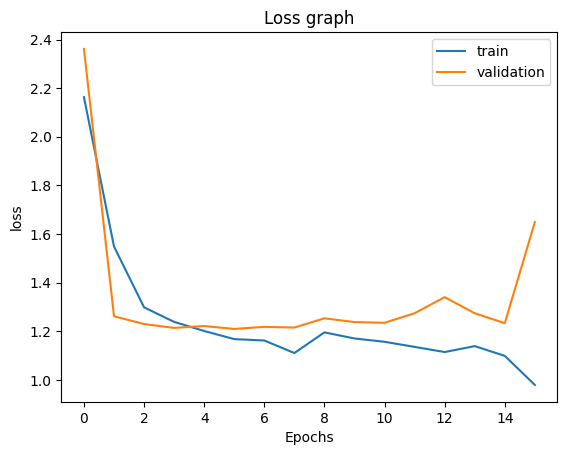

In [41]:
plt.title("Loss graph")
plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

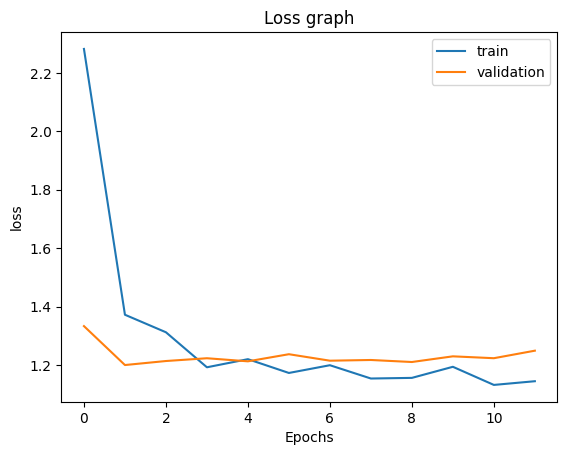

In [ ]:
plt.title("Loss graph")
plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()